# Intermediate Report 2 (20201205)

In [9]:
from IPython.display import Image

#======================

# 1. Previously 
###  What had been done so far

### 1-1
- [x] Evaluate positives with Damaging Passges 
    - FiD is position invariant

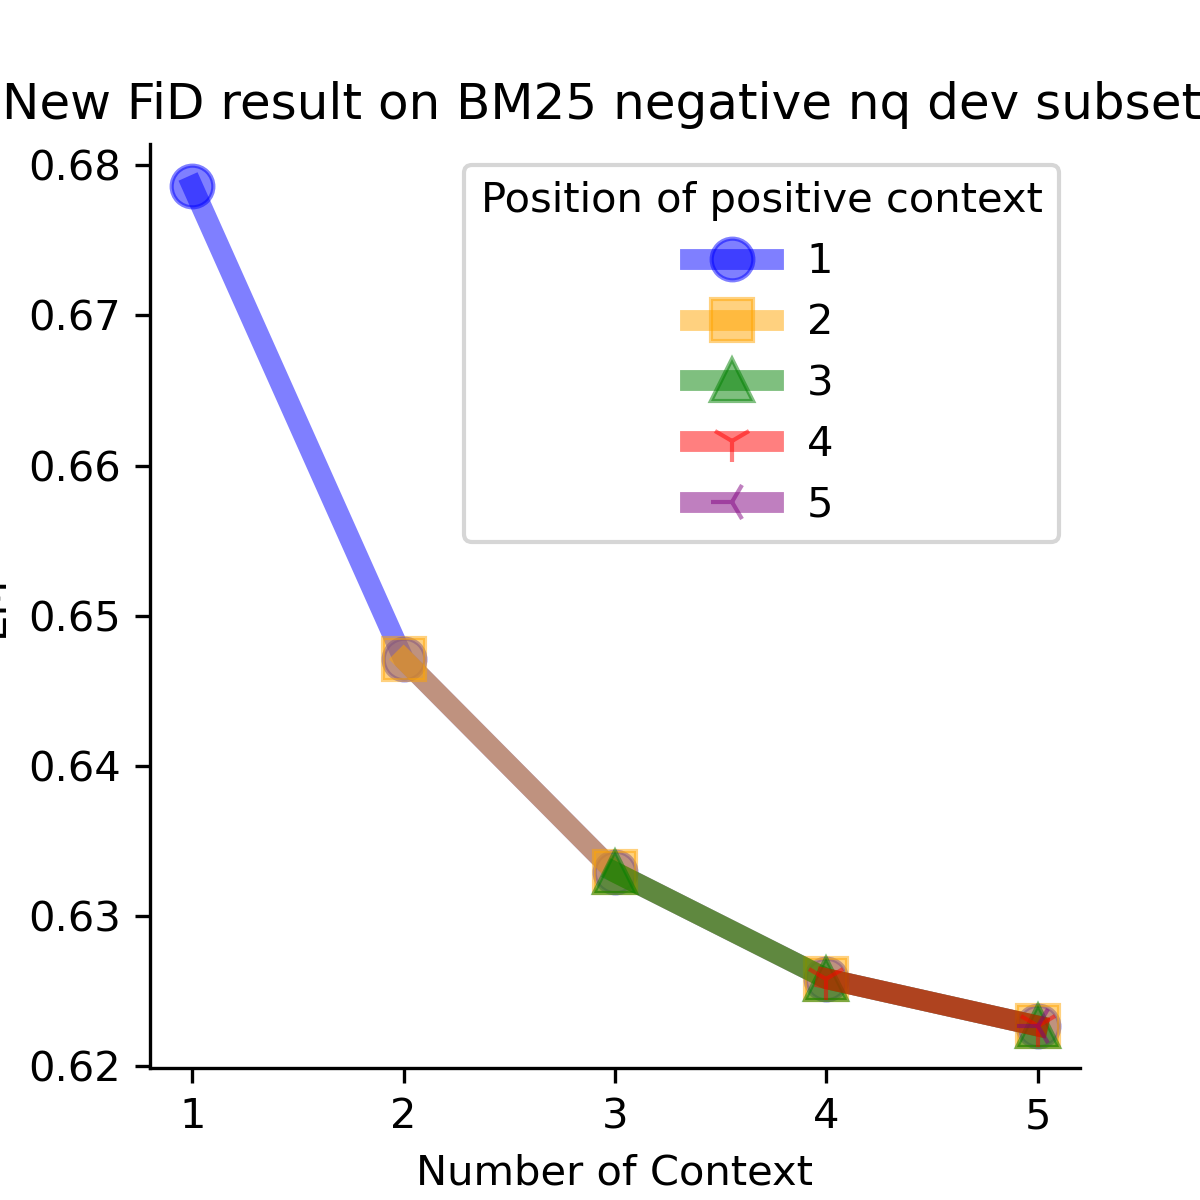

In [20]:
Image(filename='./img/New_FiDResultOnBM25HardnegativeNQdev2539.png', width=500)

### 1-2
- [x] Evaluate Postivies with Random passages Passges 
    - Adding extra random passages puts stronger boundary for better EM result by small margin (up and downs)

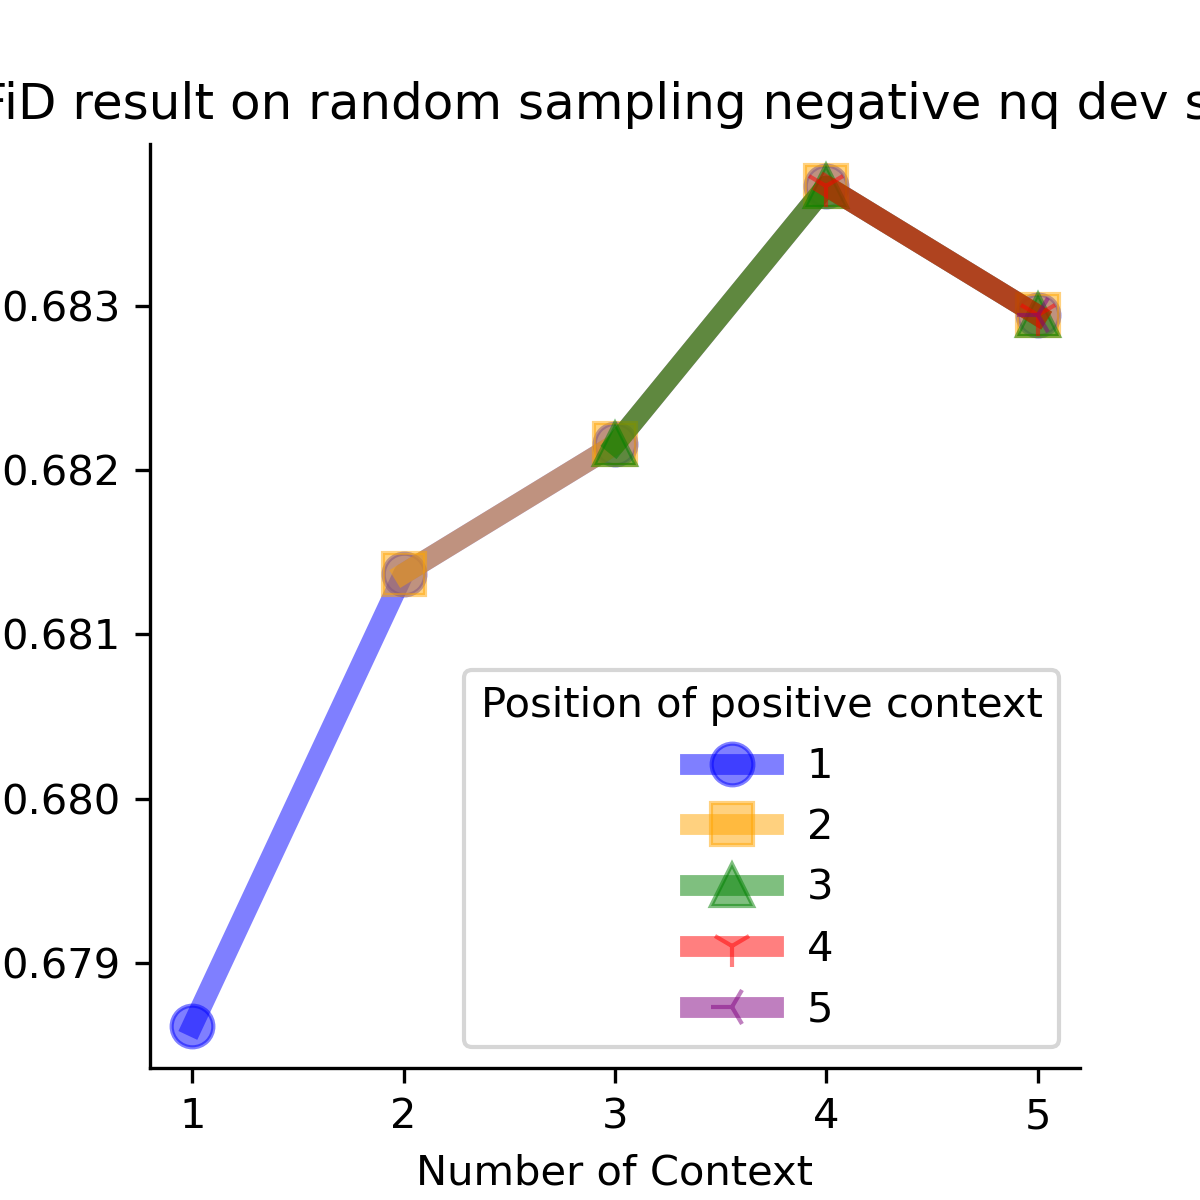

In [21]:
Image(filename='./img/New_FiDResultOnRandomSamplingnegativeNQdev2539.png', width=500)

### 1-3
- [x] Evaluate positives with Damaging Passges incrementally
    - Procedures
        : Accumulating EM of positive passages located at position 1 (blue circle) 
            - (actually position won't matter because we know FiD is position invariant) 
        : Accumulated EM counts all correct inference up to the number of context
        - e.g.)
            - a. (query, passage1) -> correct output
            - b. (query, passage1, passage2) -> wrong output
            - Eventhough b. yields incorrect inference, a. gives us correct result. 
            - Therefore, Accumulated EM upto 2 is 1
            - Details about AcEM@k are described in 3.2 Metric
    - Creates True Upperbound for the input of contexts
        - It creats true upperbound for 1 positive + 4 negative passages 

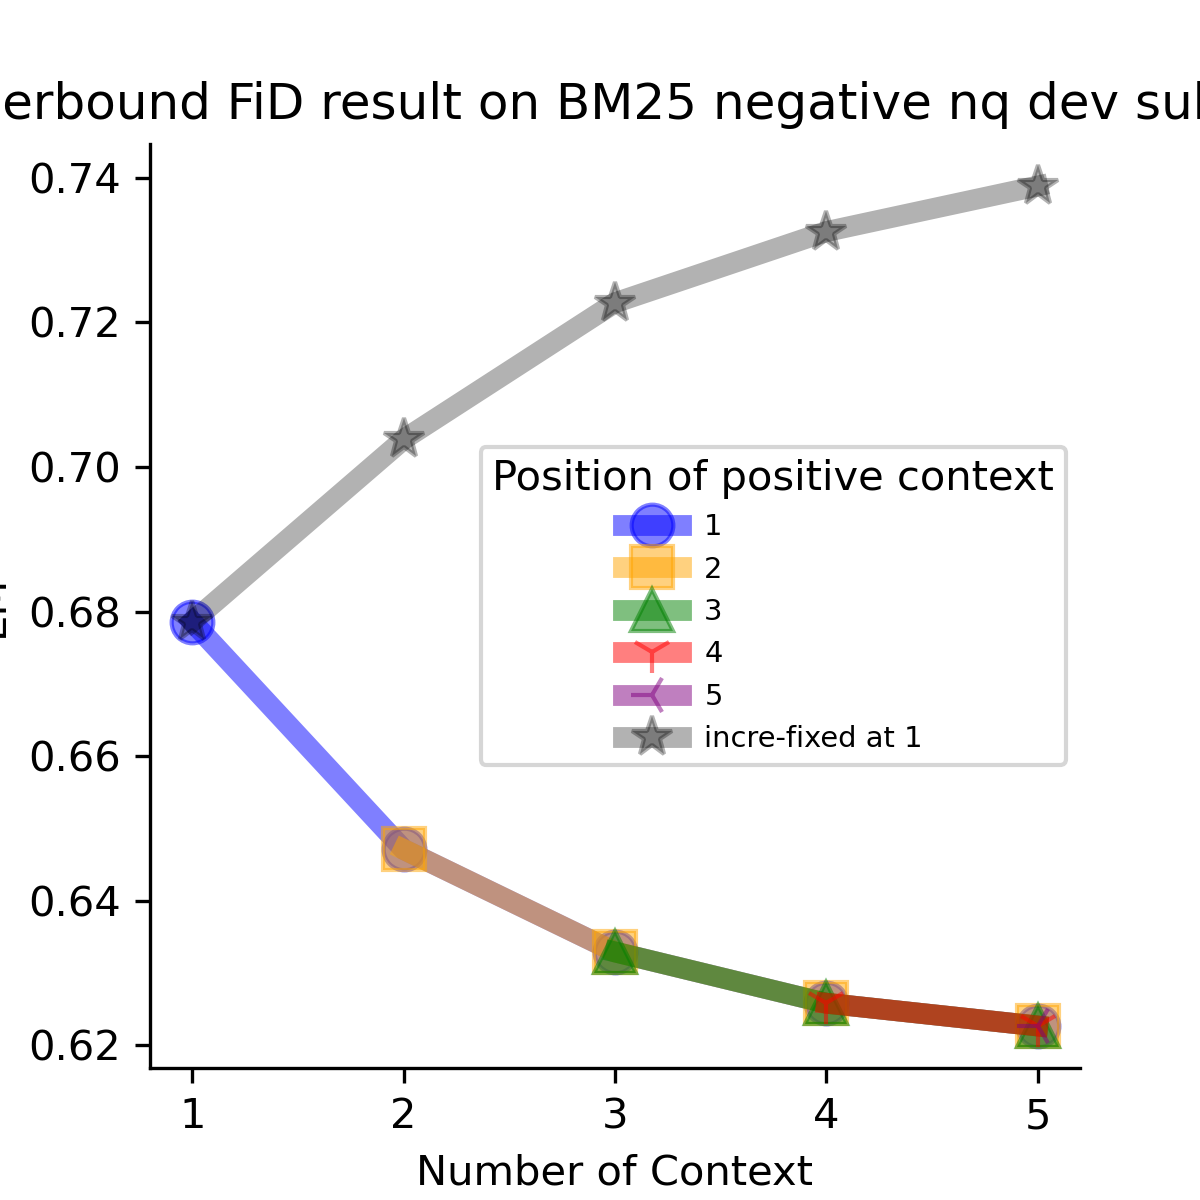

In [22]:
Image(filename='./img/Upperbound_FiDResultOnBM25HardnegativeNQdev2539.png', width=500)

- What's interesting?
- negative contexts are mostly damaging paasages
    - When comparing with Random Sampling, it shows that adding negative ctx downgrade the result
- negative contexts can also be useful
    - __negative contexts can be damaging but can provide useful information to FiD with right combination of context__

#======================

# 2. Terms & Results compared with FiD-Light

## 2-1 Terms
__Positive context(=passage)__
- Passage contains the answer

__Negative Context__
- Passges retrieved by retriever but does not contain answer
- Can be useful or damaging 
    - Mostly downgrades
    - but with right combination, can be useful

__Damaging Context__
- Passages that damaging the final output ~~with the positive context~~ when the previous inference was correct
    - strikethrough : positive context might generate the wrong answer. This is due to two reasons
        - FiD generates the wrong output even with the positive context
        - Eventhough positive context contains the answer, it's context is not sufficient enough to predict the answer

__Retrieved context__
- Passage retrieved by retriever

## 2-2 Definitions On FiD-light paper

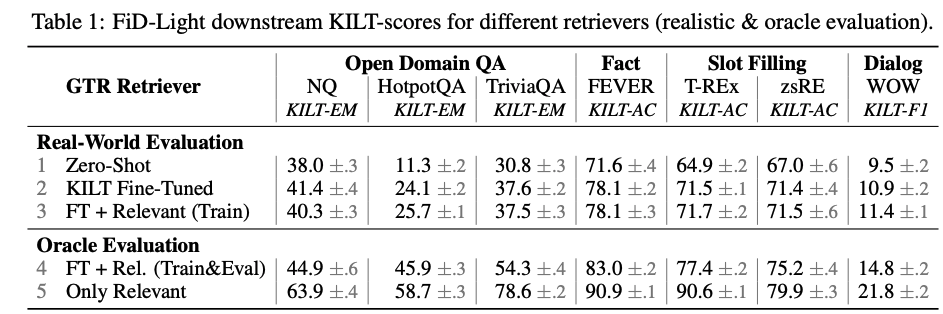

In [24]:
Image(filename='./img/gtr-oracle.png', width=700)

__Oracle experiment__ 
- (row 5) above figure
- Infuse Only all Relevant(=Positive)
    
__Realistic Oracle experiment__ 
- (row 4) above figure
- Infuse all Relevant(=Positive) + Retrieved
    
__Realistic Scenario experiment__
- Retrieved Only  

### Points on FiD-light
* On the paper they argue __Oracle experiment__ is the _Ideal Upperbound_ 
* They claimed that __Realistic Oracle experiment__ is more proper measure for the _Upperbound_  

## 2-3 Results (compared with FiD-Light)

- For __Oracle experiment__, we used only 1 __positive ctx__
- For __Realistic Oracle experiment__, we used 1 __positive ctx__ + 4 __negative ctxs__
    - Our preivous experiment is simliart to __Realistic Oracle experiment__ 
    - ;however, instead of using __retrieved ctx__, we used __negative ctxs__
    - putting more harsh standards in terms of using __negative ctxs__ instead of __retrieved ctxs__
- By showing Accumulated EM, we refutes FiD-Light's idea that __Oracle experiment is the Ideal Upperbound__  
__Realistic Oracle experiment__ can be outperformed by the __Oracle experiment__ <span style="color:red">even with negative context</span>  
Though we cannot directly compare results because they used __all positive ctx__ instead of just using 1.  

#======================

# 3. Selection Method
- Based on the experiments, now it becomes a problem of __getting right subset from the Retrieved List__

## 3-1. Selection Method Figure

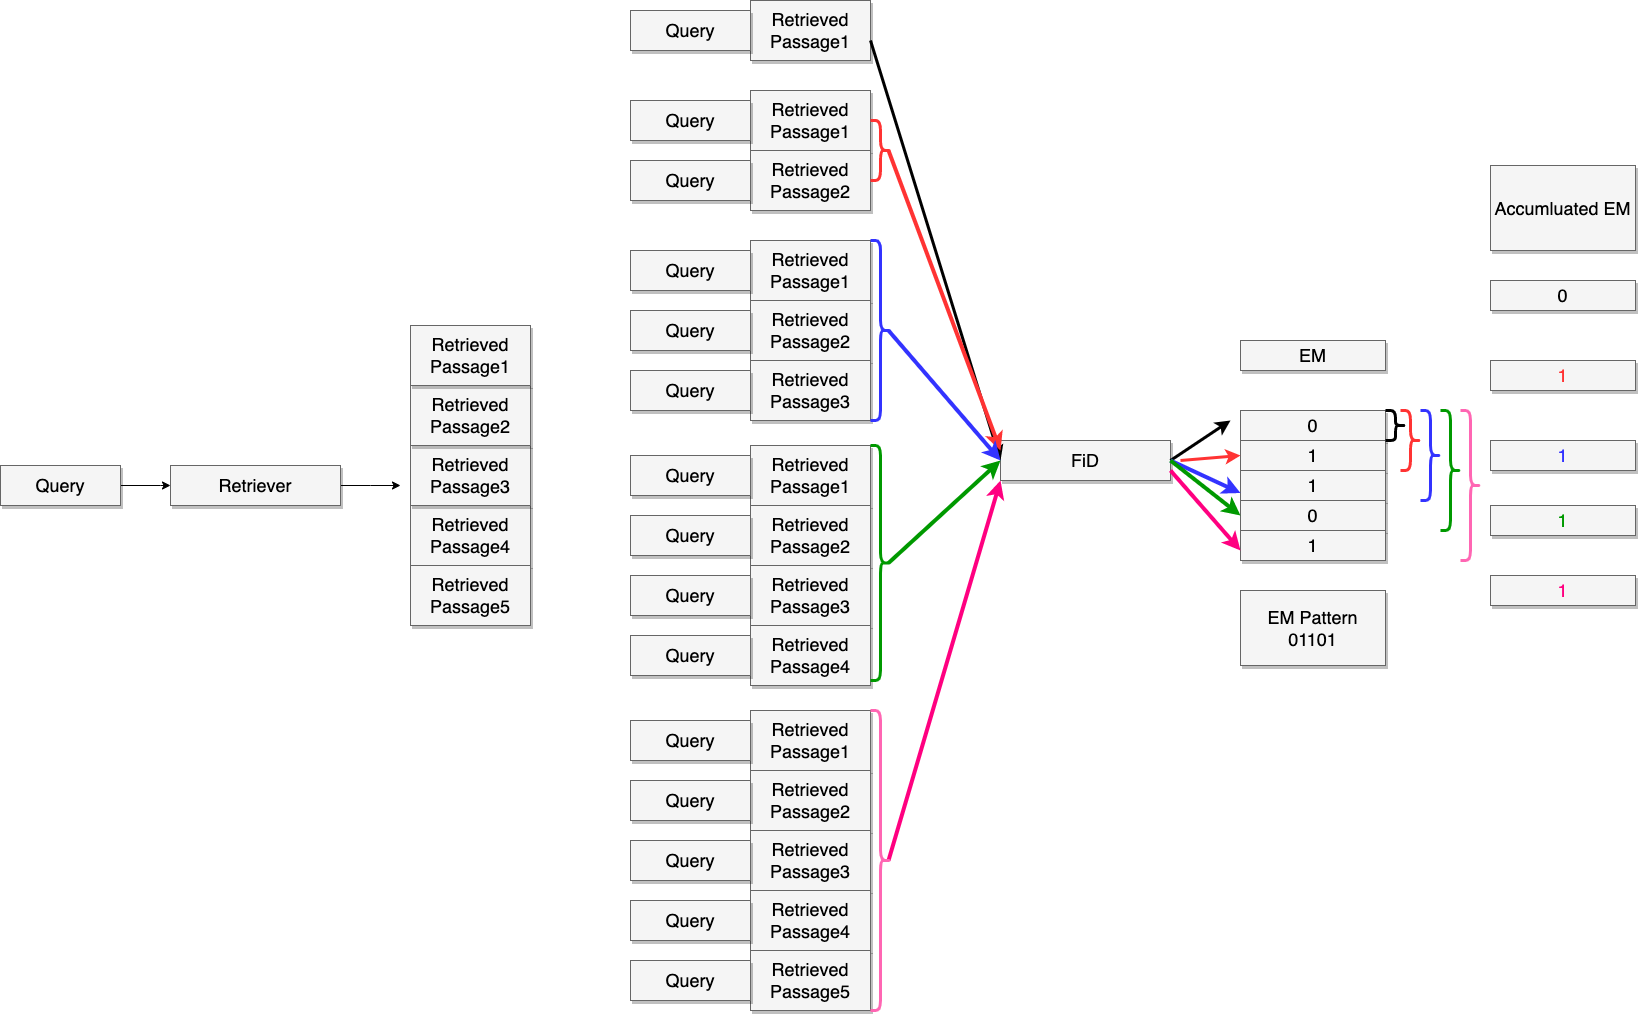

In [27]:
Image(filename='./img/selection_figure.png', width=1000)

## 3-2. Metric
###  3-2-1 .EM pattern
- Incremental results using FiD using upto k passages
- If the output matches with the answer mark it as 1. Otherwise mark it as 0
- e.g.) 01101
    - 1st digit of the EM pattern refers the EM of using top-1 retrieved passages
    - 2nd digit of the EM pattern refers the EM of using top-2 retrieved passages
    - 3rd digit of the EM pattern refers the EM of using top-3 retrieved passages  
    .....
    - Nth digit of the EM pattern refers the EM of using top-n retrieved passages

###  3-2-2. AcEM (Accumulated EM)
- measures the True Upperbound for given k-retrieved passages
- If there is 1 in upto kth digit in EM pattern, mark it as 1. Otherwise mark it as 0
- e.g.) EM pattern = __'01001'__
    - If EM pattern[:1] contains '1', then AcEM@1 = 1. Otherwise AcEM@1 = 0
        - EM pattern[:1] = 0 ->  AcEM@1 = 0
    - If EM pattern[:2] contains '1', then AcEM@2 = 1. Otherwise AcEM@2 = 0
        - EM pattern[:2] = 01 ->  AcEM@2 = 1
    - If EM pattern[:3] contains '1', then AcEM@3 = 1. Otherwise AcEM@3 = 0
        - EM pattern[:3] = 010 ->  AcEM@3 = 1  
    .....
    - If EM pattern[:k] contains '1', then AcEM@k = 1. Otherwise AcEM@k = 0
        - EM pattern[:k] = '011...' ->  AcEM@k = 1
        
###  3-2-3. Discrepancy between AcEM@k and EM pattern[k-1] 
- AcEM@k - EM pattern[k-1] : counts the damaging effect for instances
    - e.g.) Let for a given query, EM pattern is '10100'. Then AcEM@5 = 1, EM pattern[4] = 0.   
        : Interpretation 
            - AcEM@5 = 1 means that there was at least one correct inference from previous outputs.
                - that is at least one '1' in EM pattern[:5]
            - EM pattern[4] = 0 means that when using 5 passages the inference was wrong
            - So for a given query we know that there is damaging effect
            - however we don't know where and how many damaging passages present in the given k passages. 
            - To know that we need to check the EM pattern
            - For EM pattern '10100', there are 2 damaging passages at EM pattern[1] and EM pattern[3]
            
- AcEM@k - AcEM@(k-1) : the number of positive passages at k 
    - e.g.) Let for a given query, EM pattern is '00100'. Then AcEM@3 = 1, AcEM@2 = 0  
        : Interpretation
            - When using three passages, the inference is corret. AcEM@3 = 1
            - When using incrementally upto 2 passages, the inferences(two inferences) are wrong. AcEM@2 = 0
            - so AcEM@k - AcEM@(k-1) measures the number of positive passages at k 

## 3-3. Metric  Selection Methods (6 ways)

##### E.G) EM_pattern = '00011011000'
- passages corresponding to colored digit are input

#### Method1. Include passages that corresponds to 1s
'00011011000'  -> 000<span style="color:red">1</span><span style="color:red">1</span>0<span style="color:red">1</span><span style="color:red">1</span>000  
- red 1s

#### Method2. Include passages that corresponds to first 1s
'00011011000'  -> 
000<span style="color:red">1</span>10<span style="color:red">1</span>1000  
- red 1s
- removing consecutive passages when the previous output is correct as well

#### Method3. Include passages that corresponds to 1s + Included First appeared consecutive 0s
'00011011000'  -> 
<span style="color:blue">0</span><span style="color:blue">0</span><span style="color:blue">0</span><span style="color:red">1</span></span><span style="color:red">1</span>0<span style="color:red">1</span></span><span style="color:red">1</span>000  
- red 1s and blue 0s
- usually top-retrieved results contain the answer 

#### Method4. Include passages that corresponds to first 1s + Included First appeared consecutive 0s
'00011011000'  -> 
<span style="color:blue">0</span><span style="color:blue">0</span><span style="color:blue">0</span><span style="color:red">1</span>10<span style="color:red">1</span>1000  
- red 1s and blue 0s
- removing consecutive passages when the previous output is correct as well
- usually top-retrieved results contain the answer 

#### Method5. Include passages that corresponds to 1s + Remove only damaging
'00011011000'  -> 
<span style="color:blue">0</span><span style="color:blue">0</span><span style="color:blue">0</span><span style="color:red">1</span></span><span style="color:red">1</span>0<span style="color:red">1</span></span><span style="color:red">1</span>0<span style="color:blue">0</span><span style="color:blue"><span style="color:blue">0</span><span style="color:blue"> 
- red 1s and blue 0s
- only removes damaging passages for comparison with Method3, Method4
- usually top-retrieved results contain the answer 

#### Method6. Include passages that corresponds to first 1s  + Remove only damaging
'00011011000'  -> 
<span style="color:blue">0</span><span style="color:blue">0</span><span style="color:blue">0</span><span style="color:red">1</span>10<span style="color:red">1</span>10<span style="color:blue">0</span><span style="color:blue">0</span>
- red 1s and blue 0s
- removing consecutive passages when the previous output is correct as well
- only removes damaging passages for comparison with Method3, Method4
- usually top-retrieved results contain the answer 

#======================

# 4. Selection Method Result

## 4-1. NQ(KILT) dev FiD with BM25 negative passages
- __1 positive + 4 negative passages__ 
- __Number of input passages varies over__ the Methods and EM pattern
- Since we are injecting negatives to the input, EM drops as number of contexts increases
- Lowerbound for this experiment is __EM with top-1(only positive context)__ == __AcEM@1 (only positive context)__ 
- Upperbound for this experiment is __AcEM@5__ 

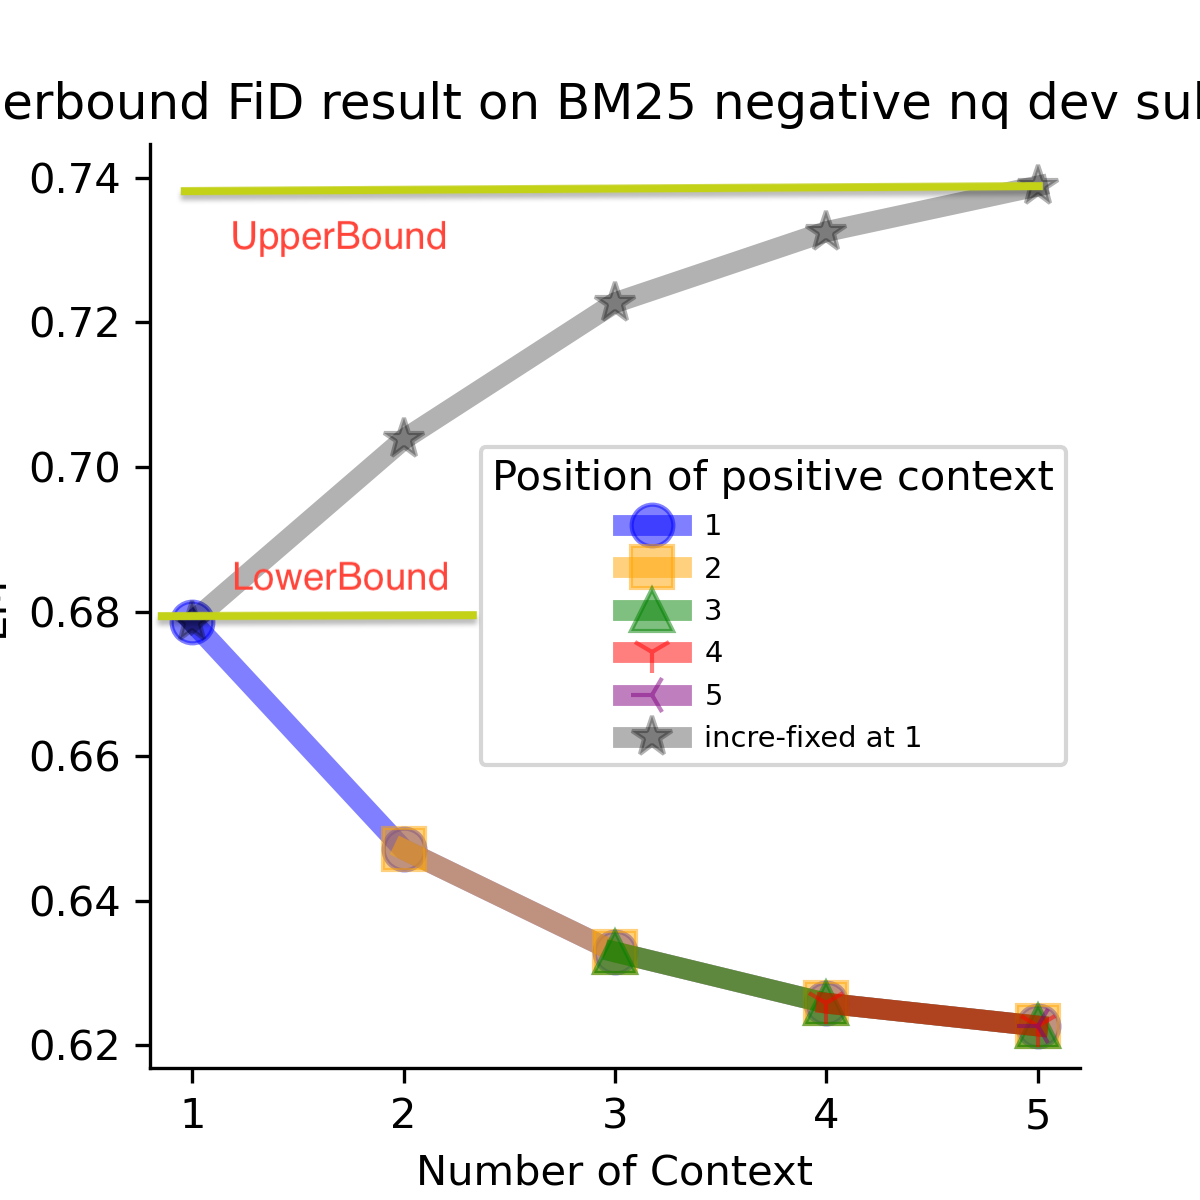

In [28]:
Image(filename='./img/Upperbound_FiDResultOnBM25HardnegativeNQdev2539_upper_lower.png', width=500)

| Method  | EM      |
|---------|---------|
| Lower   | 0.67861 |
| Upper   | 0.73887 |
| Method1 | 0.71130 |
| Method2 | 0.70972 |
| Method3 | 0.73651 |
| Method4 | 0.73611 |
| Method5 | 0.68452 |
| Method6 | 0.68609 |

#### Results
##### Summary
: Keeping first consecutive 0's + adding all 1 context close to Upperbound; however, only keep first 1s shows  comparable result  
: __Keeping first consecutive 0's__ was natural since we included and positioned the positive context at top-1 


- Upperbound 0.73887      
- Method3. '00011011000'  -> 
<span style="color:blue">0</span><span style="color:blue">0</span><span style="color:blue">0</span><span style="color:red">1</span></span><span style="color:red">1</span>0<span style="color:red">1</span></span><span style="color:red">1</span>000  (__0.73651__)     

- Method4. '00011011000'  -> 
<span style="color:blue">0</span><span style="color:blue">0</span><span style="color:blue">0</span><span style="color:red">1</span>10<span style="color:red">1</span>1000 (_0.73611_)    

- Method1. '00011011000'  -> 000<span style="color:red">1</span><span style="color:red">1</span>0<span style="color:red">1</span><span style="color:red">1</span>000 (0.71130)    

- Method2. '00011011000'  -> 000<span style="color:red">1</span>10<span style="color:red">1</span>1000  (0.70972)        
- Method6. '00011011000'  -> <span style="color:blue">0</span><span style="color:blue">0</span><span style="color:blue">0</span><span style="color:red">1</span>10<span style="color:red">1</span>10<span style="color:blue">0</span><span style="color:blue">0</span> (0.68609)    

- Method5. '00011011000'  -> <span style="color:blue">0</span><span style="color:blue">0</span><span style="color:blue">0</span><span style="color:red">1</span><span style="color:red">1</span>0<span style="color:red">1</span></span><span style="color:red">1</span>0<span style="color:blue">0</span><span style="color:blue">0</span>    (0.68452) 

- Lowerbound 0.67861   

- __Adding Extra 1s__ does not affect the inference
    - enhancing EM by small margin 
        - Method2 -> Method1 : 0.00158
        - Method4 -> Method3 : 0.0004
    - sometime degrading result
        - Method6 -> Method5 : -0.00157

- __Removing Extra 0s(meaning all 0s except first consecutive 0S)__ increases EM by 5%
    - Method6 -> Method4 : 0.68609 -> 0.73611
    - Method5 -> Method3 : 0.68452 -> 0.73651
    - Close to Upperbound

- __Removing All 0s(including first consecutive 0S)__ descreases EM by 3%
    - Method4 -> Method2 : 0.73611 -> 0.70972
    - Method3 -> Method1 : 0.73651 -> 0.71130
    - Between Lower and Upper Bound

## 4-2. NQ dev with FiD retrieved passages
- __Only retrieved passages__ 
- __Number of input passages varies over__ the Methods and EM pattern
- EM increases as number of contexts increases 
- Lowerbound for this experiment is __EM with top-k__
- Upperbound for this experiment is __AcEM@k__ 

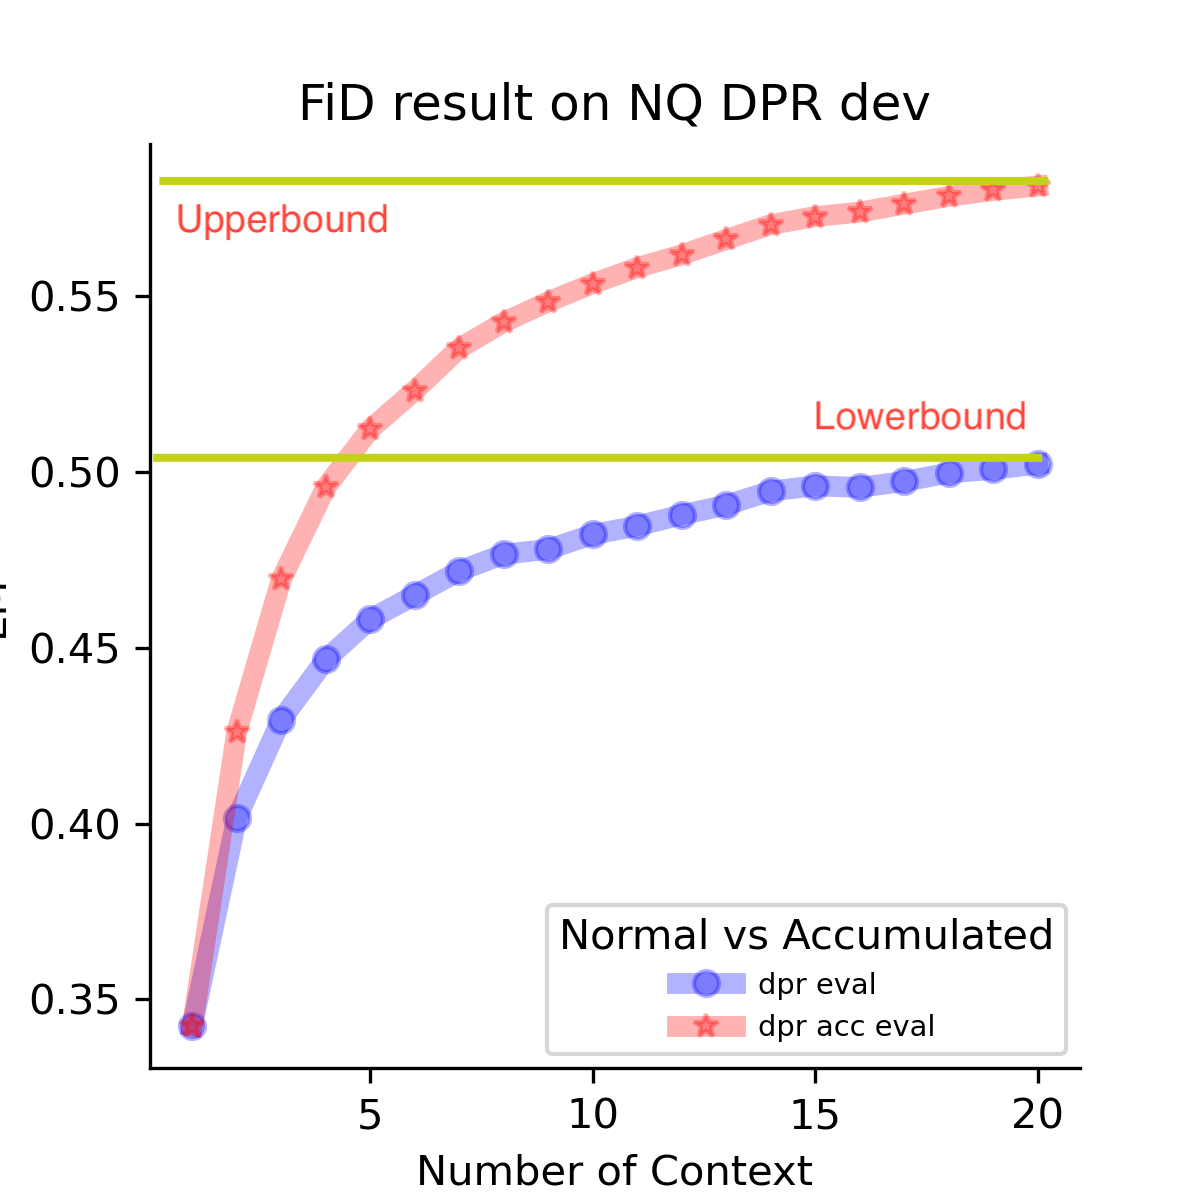

In [12]:
Image(filename='./img/FiD_NQ_DPR_AcEM_EM_upper_lower_20.png', width=500)

| Method  | EM      |
|---------|---------|
| Lower   | 0.50211 |
| Upper   | 0.58113 |
| Method1 | 0.55144 |
| Method2 | 0.53796 |
| Method3 | 0.57839 |
| Method4 | 0.57690 |
| Method5 | 0.53659 |
| Method6 | 0.53796 |

#### Results
##### Summary
: Keeping first consecutive 0's + adding all 1 context close to Upperbound; however, only keep first 1s shows  comparable result  
: __Keeping first consecutive 0's__ is still valid though this is realistic scenario. Here we don't know that 1st passsage is the positive unlike previous ones; however, still shows the best results

- Upperbound 0.58113      
- Method3. '00011011000'  -> 
<span style="color:blue">0</span><span style="color:blue">0</span><span style="color:blue">0</span><span style="color:red">1</span></span><span style="color:red">1</span>0<span style="color:red">1</span></span><span style="color:red">1</span>000  (__0.57839__)     

- Method4. '00011011000'  -> 
<span style="color:blue">0</span><span style="color:blue">0</span><span style="color:blue">0</span><span style="color:red">1</span>10<span style="color:red">1</span>1000 (_0.57690_)    

- Method1. '00011011000'  -> 000<span style="color:red">1</span><span style="color:red">1</span>0<span style="color:red">1</span><span style="color:red">1</span>000 (0.55144)    

- Method2. '00011011000'  -> 000<span style="color:red">1</span>10<span style="color:red">1</span>1000  (0.53796)        
- Method6. '00011011000'  -> <span style="color:blue">0</span><span style="color:blue">0</span><span style="color:blue">0</span><span style="color:red">1</span>10<span style="color:red">1</span>10<span style="color:blue">0</span><span style="color:blue">0</span> (0.53796)    

- Method5. '00011011000'  -> <span style="color:blue">0</span><span style="color:blue">0</span><span style="color:blue">0</span><span style="color:red">1</span><span style="color:red">1</span>0<span style="color:red">1</span></span><span style="color:red">1</span>0<span style="color:blue">0</span><span style="color:blue">0</span>    (0.53659) 

- Lowerbound 0.50211   

- __Adding Extra 1s__ does not affect the inference
    - enhancing EM by small margin 
        - Method2 -> Method1 : 0.01348
        - Method4 -> Method3 : 0.00149
    - sometimes degrading result
        - Method6 -> Method5 : -0.00137

- __Removing Extra 0s(meaning all 0s except first consecutive 0S)__ increases EM by 4%(0.03894, 0.0418 respectively)
    - Method6 -> Method4 : 0.53796 -> 0.57690 (0.03894)
    - Method5 -> Method3 : 0.53659 -> 0.57839 (0.0418)
    - Close to Upperbound

- __Removing All 0s(including first consecutive 0S)__ descreases EM by 3%
    - Method4 -> Method2 : 0.57690 -> 0.53796 (-0.03894)
    - Method3 -> Method1 : 0.57839 -> 0.55144 (-0.02695)

## 4-3. Summary
- Both 4-1,4-2 points out that there is a room for improvement (upperbound)
- Although datasets of 4-1 and 4-2 are different, __BEST SELECTION METHOD__ for each dataset is same
    - 4-1 is `Realistic Oracle experiment with negative contexts (instead of using relative contexts)`  
    - 4-2 is `Realistic Scenario`  
    - __BEST SELECTION METHOD__
        - Keeping first consecutive 0's + adding all 1 context
    - __Alternative BEST SELECTION METHOD__
        - Keeping first consecutive 0's + adding only first 1 context
        
- Both 4-1,4-2 demonstrates
    - Need for excluding damaging passages, all results are higher than lowerbounds by just removing damages
    - Keeping first consecutive 0s is important (almost close to upperbound)
    - Removing Extra 0s improves the result
        - What is Extra 0s ? We differentiate the 0s in EM pattern by follwing :   
            case 1. __initial consecutive 0s__ : 0s appeared on the very beginning of the EM pattern.   
            case 2. Damaging 0 : the first 0 appeared right after when the previous inference is true  
            case 3. Extra 0s : are the ones  except 1st and 2nd cases mentioned above  

#=================

# 5. Data Pre

===================
## 5-1. Retrieval
### NQ

|Data|NQ-DEV|NQ-TEST|
|------|---|---|
|DPR|O|O|
|SEAL|O|O|
|CONTRIEVER|O|O|


### TQA retrieval

|Data|TQA-DEV|TQA-TEST|
|------|---|---|
|DPR|O|O|
|SEAL|O|O|
|CONTRIEVER|O|O|


===================

## 5-2. Incremental Inference 
### NQ

|Data|NQ-DEV|NQ-TEST|
|------|---|---|
|DPR|O|O|
|SEAL|O|X|
|CONTRIEVER|O|X|


### TQA

|Data|TQA-DEV|TQA-TEST|
|------|---|---|
|DPR|O|$\triangle$(on the queue)|
|SEAL|O(needs checking)|X|
|CONTRIEVER|O(needs checking)|X|

*  O = incremental results and plotting
this was done using nq reader...
- depreciated

|Data|TQA-DEV|TQA-TEST|
|------|---|---|
|DPR|O(needs checking)|X|
|SEAL|$\triangle$(on the queue)|X|
|CONTRIEVER|$\triangle$(on the queue)|X|

===================

# 6. Selection Methods

## 6-1. Preparing Data for Selection Inference 
- dataset on 6 methods

### NQ

|Data|NQ-DEV|NQ-TEST|
|------|---|---|
|DPR|O|O|
|SEAL|X|X|
|CONTRIEVER|O|X|


### TQA - Preparing Data for Selection Inference 

|Data|TQA-DEV|TQA-TEST|
|------|---|---|
|DPR|X|X|
|SEAL|X|X|
|CONTRIEVER|X|X|

===================

## 6-2 Selection Methods Eval
- Inference on 6 methods

### NQ 

|Data|NQ-DEV|NQ-TEST|
|------|---|---|
|DPR|O|O|
|SEAL|X|X|
|CONTRIEVER|X|X|


### TQA 

|Data|TQA-DEV|TQA-TEST|
|------|---|---|
|DPR|X|X|
|SEAL|X|X|
|CONTRIEVER|X|X|

===================


# Graph

## NQ DEV DPR 

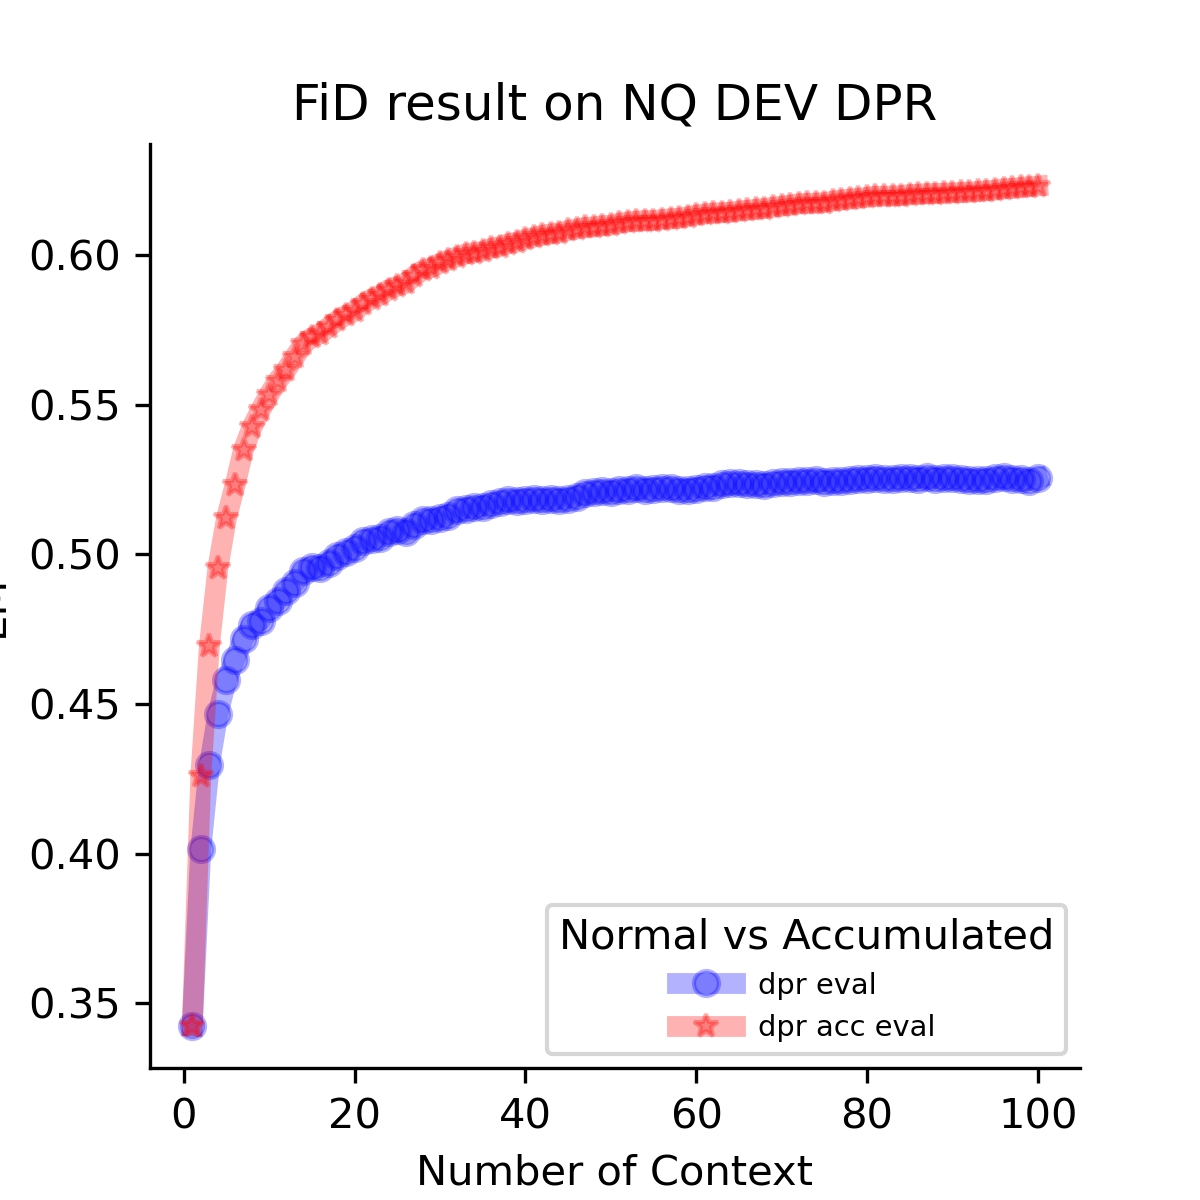

In [13]:
Image(filename='./img/NQ_DEV_DPR_AcEM_EM_100.png', width=500)

#### Sample_size 100 Results
##### Summary
: Keeping first consecutive 0's + adding all 1 context close to Upperbound; however, only keep first 1s shows  comparable result  
: __Keeping first consecutive 0's__ was natural since we included and positioned the positive context at top-1 


- Upperbound 0.62304 
- Method3. '00011011000'  -> 
<span style="color:blue">0</span><span style="color:blue">0</span><span style="color:blue">0</span><span style="color:red">1</span></span><span style="color:red">1</span>0<span style="color:red">1</span></span><span style="color:red">1</span>000  (__0.61836__)     

- Method4. '00011011000'  -> 
<span style="color:blue">0</span><span style="color:blue">0</span><span style="color:blue">0</span><span style="color:red">1</span>10<span style="color:red">1</span>1000 (_0.61744_)    

- Method1. '00011011000'  -> 000<span style="color:red">1</span><span style="color:red">1</span>0<span style="color:red">1</span><span style="color:red">1</span>000 (0.58102)    

- Method2. '00011011000'  -> 000<span style="color:red">1</span>10<span style="color:red">1</span>1000  (0.563663)        
- Method6. '00011011000'  -> <span style="color:blue">0</span><span style="color:blue">0</span><span style="color:blue">0</span><span style="color:red">1</span>10<span style="color:red">1</span>10<span style="color:blue">0</span><span style="color:blue">0</span> (0.560123)    

- Method5. '00011011000'  -> <span style="color:blue">0</span><span style="color:blue">0</span><span style="color:blue">0</span><span style="color:red">1</span><span style="color:red">1</span>0<span style="color:red">1</span></span><span style="color:red">1</span>0<span style="color:blue">0</span><span style="color:blue">0</span>    (0.55224) 

- Lowerbound 0.52586

## NQ TEST DPR 

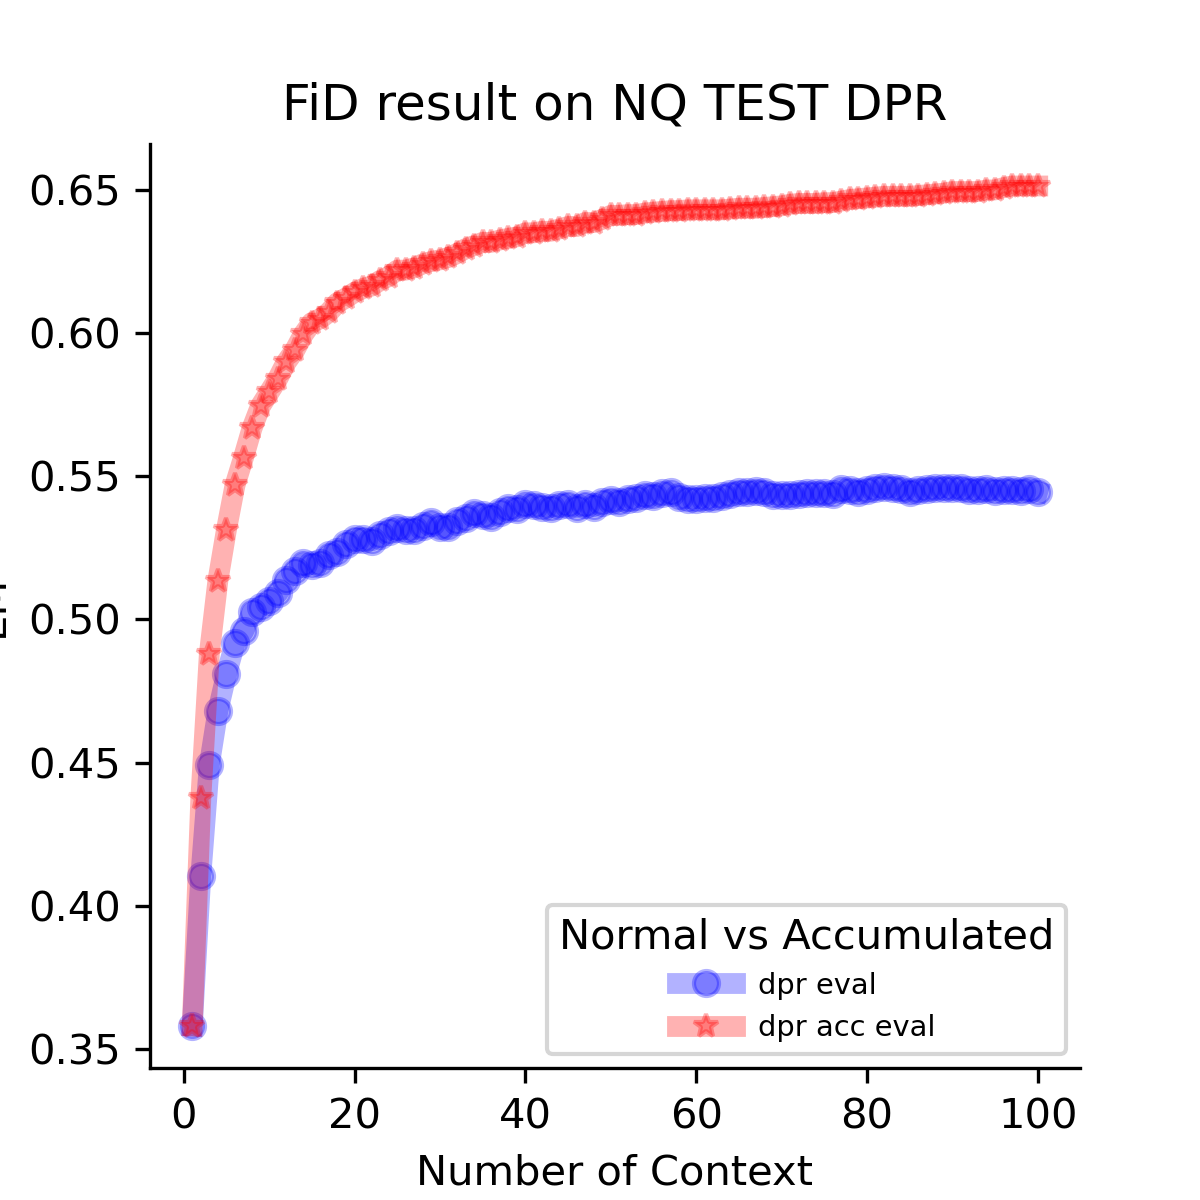

In [14]:
Image(filename='./img/NQ_TEST_DPR_AcEM_EM_100.png', width=500)

## NQ DEV Contriever 

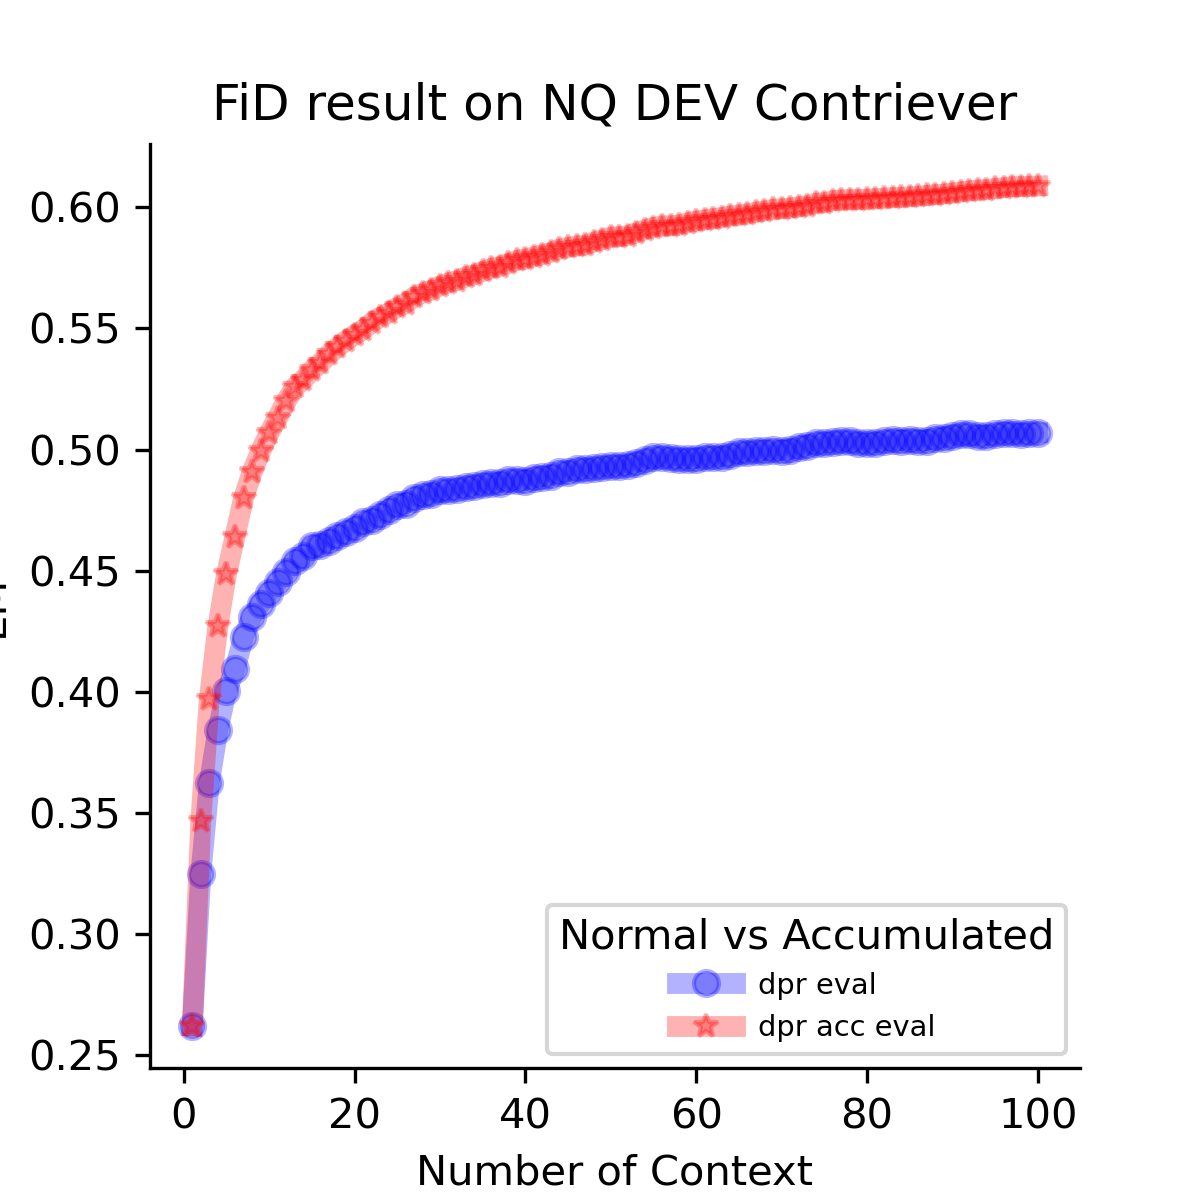

In [15]:
Image(filename='./img/NQ_DEV_Contriever_AcEM_EM_100.png', width=500)